# Diffusion U-Net

> Unconditional U-net from scratch

Adapted from

- [Lesson 24](https://www.youtube.com/watch?v=DH5bp6zTPB4&list=PLfYUBJiXbdtRUvTUYpLdfHHp9a58nWVXP&index=16)

In [1]:
#| default_exp diffusion_unet

In [2]:
# |export
import math
from functools import partial
from pathlib import Path

import matplotlib.pyplot as plt
import torch
import torch.nn.functional as F
from torch import nn, tensor
from torch.optim import lr_scheduler
from tqdm import tqdm

from slowai.cos_revisited import aesthetics, denoisify, noisify
from slowai.ddpm import get_dls as get_fashion_dls
from slowai.learner import DeviceCB, Learner, MetricsCB, ProgressCB, TrainCB, def_device
from slowai.sgd import BatchSchedulerCB
from slowai.utils import show_image, show_images

In [3]:
aesthetics()

In [4]:
dls = get_fashion_dls(bs=512)

## Time embedding

Time embeddings are neccesary to achieve modeling high performance

-math.log(max_period)=-9.210340371976184


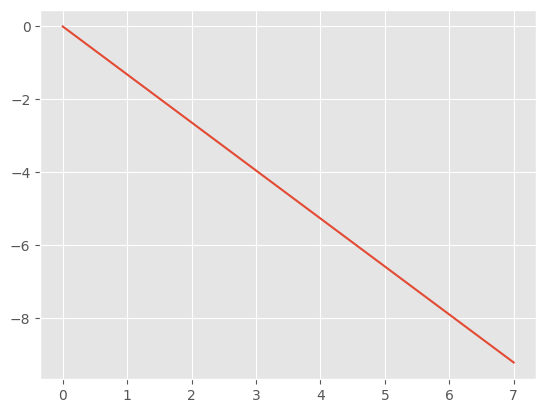

In [5]:
emb_dim = 16

# This was thought to be the longest sequence that a transformer
# should be able to handle, even though nowadays sequences can
# be much longer
max_period = 10_000

print(f"{-math.log(max_period)=}")
exponent = -math.log(max_period) * torch.linspace(0, 1, emb_dim // 2)
plt.plot(exponent);

They are computed by computing the outer product of the time vector, `ts` with the exponent function...

In [6]:
bs = 100
ts = torch.linspace(-10, 10, bs)

embedding = ts[:, None].float() * exponent.exp()[None, :]
embedding.shape

torch.Size([100, 8])

> note here that, so far, the embeddings aren't very different

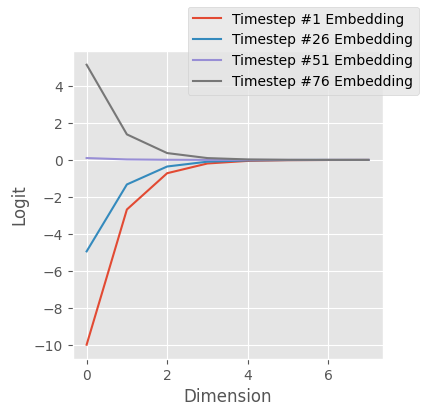

In [7]:
fig, ax = plt.subplots(figsize=(4, 4))
for i in range(0, bs, 25):
    ax.plot(embedding[i], label=f"Timestep #{i+1} Embedding")
ax.set(ylabel="Logit", xlabel="Dimension")
fig.legend();

...and projected into cosine and sine space, and then concatenated.

In [8]:
embedding = torch.cat([embedding.sin(), embedding.cos()], dim=-1)
embedding.shape

torch.Size([100, 16])

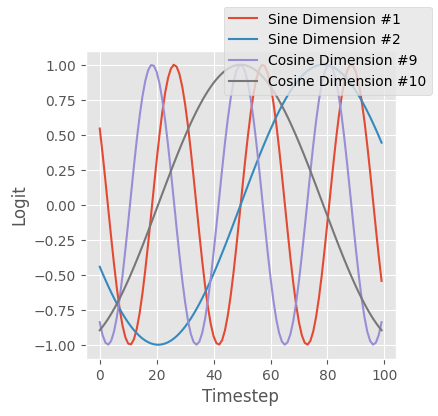

In [9]:
fig, ax = plt.subplots(figsize=(4, 4))
for i in range(2):
    ax.plot(embedding[:, i], label=f"Sine Dimension #{i+1}")
for i in range(8, 10):
    ax.plot(embedding[:, i], label=f"Cosine Dimension #{i+1}")
ax.set(ylabel="Logit", xlabel="Timestep")
fig.legend();

Overall, this results in a time embedding that is similar to its neighbors, but is overall very diverse. This figure demonstrates this, where the first column is similar to the second column, but dissimilar to the 100th column.

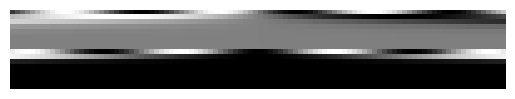

In [10]:
show_image(embedding.T);

We can consolidate this.

In [11]:
# |export
def timestep_embedding(ts, emb_dim, max_period=10_000):
    exponent = -math.log(max_period) * torch.linspace(
        0, 1, emb_dim // 2, device=ts.device
    )
    embedding = ts[:, None].float() * exponent.exp()[None, :]
    embedding = torch.cat([embedding.sin(), embedding.cos()], dim=-1)
    return embedding

Editting the number of dimensions increases the column size

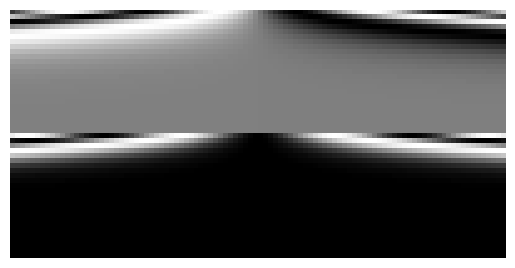

In [12]:
show_image(timestep_embedding(ts, 50).T);

Decreasing the max_period increases inter-column heterogeneity.

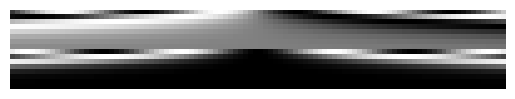

In [13]:
show_image(timestep_embedding(ts, 16, 100).T);

Let's reimplement the U-net with time

In [14]:
# |export
class Conv(nn.Module):
    def __init__(self, c_in, c_out, ks=3, stride=1):
        super().__init__()
        self.norm = nn.BatchNorm2d(c_in)
        self.act = nn.ReLU()
        self.conv = nn.Conv2d(
            c_in,
            c_out,
            stride=stride,
            kernel_size=ks,
            padding=ks // 2,
            bias=False,
        )

    def forward(self, x):
        x = self.norm(x)
        x = self.act(x)
        x = self.conv(x)
        return x

In [15]:
# |export
class EmbeddingPreactResBlock(nn.Module):
    def __init__(self, t_embed, c_in, c_out, ks=3, stride=2):
        super().__init__()
        self.t_embed = t_embed
        self.c_in = c_in
        self.c_out = c_out

        self.t_emb_proj = nn.Linear(t_embed, c_out * 2)
        self.conv_a = Conv(c_in, c_out)
        self.conv_b = Conv(c_out, c_out)
        if c_in != c_out:
            self.id_conv = nn.Conv2d(c_in, c_out, kernel_size=1)
        else:
            self.id_conv = None

    def forward(self, x_orig, t_emb):
        # non-residual link
        x = self.conv_a(x_orig)
        t_emb = self.t_emb_proj(F.relu(t_emb))[:, :, None, None]
        scale, shift = torch.chunk(t_emb, 2, dim=1)
        x = x * (1 + scale) + shift
        x = self.conv_b(x)

        # residual link
        xr = self.id_conv(x_orig) if self.id_conv else x_orig

        return x + xr

In [16]:
# |export
class SaveTimeActivationMixin:
    def forward(self, x, t):
        self.output = super().forward(x, t)
        return self.output

In [17]:
# |export
class TResBlock(
    SaveTimeActivationMixin,
    EmbeddingPreactResBlock,
):
    ...

In [18]:
# |export
class TDownblock(nn.Module):
    def __init__(self, t_embed, c_in, c_out, downsample=True, n_layers=1):
        super().__init__()
        self.t_embed = t_embed
        self.c_in = c_in
        self.c_out = c_out
        self.downsample = downsample
        self.n_layers = n_layers

        self.convs = nn.ModuleList()
        self.convs.append(TResBlock(t_embed, c_in, c_out, stride=1))
        for _ in range(n_layers - 1):
            self.convs.append(TResBlock(t_embed, c_out, c_out, stride=1))
        self.downsampler = nn.Conv2d(c_out, c_out, kernel_size=3, stride=2, padding=1)

    def forward(self, x, t):
        for conv in self.convs:
            x = conv(x, t)
        if self.downsample:
            x = self.downsampler(x)
        return x

In [19]:
# |export
class TUpblock(nn.Module):
    def __init__(self, t_embed, c_in, c_out, upsample=True, n_layers=1):
        super().__init__()
        self.t_embed = t_embed
        self.c_in = c_in
        self.c_out = c_out
        self.upsample = upsample
        self.n_layers = n_layers

        self.upsampler = nn.Sequential(
            nn.Upsample(scale_factor=2),
            nn.Conv2d(c_in, c_in, kernel_size=3, padding=1),
        )
        self.convs = nn.ModuleList()
        for _ in range(n_layers - 1):
            self.convs.append(TResBlock(t_embed, c_in * 2, c_in, stride=1))
        self.convs.append(TResBlock(t_embed, c_in * 2, c_out, stride=1))

    @classmethod
    def from_downblock(cls, downblock):
        return cls(
            t_embed=downblock.t_embed,
            c_in=downblock.c_out,
            c_out=downblock.c_in,
            upsample=downblock.downsample,
            n_layers=downblock.n_layers,
        )

    def forward(self, x, downblock, t):
        if self.upsample:
            x = self.upsampler(x)
        for up, down in zip(self.convs, reversed(downblock.convs)):
            x = up(torch.cat((x, down.output), dim=1), t)
        return x

In [20]:
# |export
class TimeEmbeddingMLP(nn.Module):
    def __init__(self, c_in, c_out):
        super().__init__()
        self.c_in = c_in
        self.c_out = c_out
        self.time_emb_mlp = nn.Sequential(
            nn.BatchNorm1d(c_in),
            nn.Linear(c_in, c_out),
            nn.ReLU(),
            nn.Linear(c_out, c_out),
        )

    def forward(self, t):
        # Look up the sin/cos embedding  of the time step
        x = timestep_embedding(t, self.c_in).to(t.device)
        # Allow the model to slightly modify the embeddings
        x = self.time_emb_mlp(x)
        return x

In [21]:
# |export
class TUnet(nn.Module):
    """Diffusion U-net with a diffusion time dimension"""

    def __init__(
        self,
        nfs=(224, 448, 672, 896),
        n_blocks=(3, 2, 2, 1, 1),
        color_channels=3,
    ):
        assert len(n_blocks) - 1 == len(nfs)
        super().__init__()

        self.time_embedding = TimeEmbeddingMLP(nfs[0], 4 * nfs[0])
        t_embed = self.time_embedding.c_out

        self.start = nn.Conv2d(
            color_channels, nfs[0], kernel_size=(3, 3), stride=(1, 1), padding=(1, 1)
        )
        self.downblocks = nn.ModuleList()
        self.upblocks = nn.ModuleList()
        for c_in, c_out, n_layers in zip(nfs, nfs[1:], n_blocks):
            db = TDownblock(
                t_embed,
                c_in,
                c_out,
                n_layers=n_layers,
            )
            self.downblocks.append(db)
            self.upblocks.insert(0, TUpblock.from_downblock(db))
        self.middle = TResBlock(t_embed, nfs[-1], nfs[-1], stride=1)
        self.end = Conv(nfs[0], color_channels)

    def forward(self, x_t, t):
        t = self.time_embedding(t)
        x = self.start(x_t)
        for db in self.downblocks:
            x = db(x, t)
        x = self.middle(x, t)
        for ub, db in zip(self.upblocks, reversed(self.downblocks)):
            x = ub(x, db, t)
        return self.end(x)

In [22]:
# |export
class FashionDDPM(TrainCB):
    def before_batch(self, learn):
        x0, _ = learn.batch
        learn.batch = noisify(x0)

    def predict(self, learn):
        (x_t, t), _ = learn.batch
        learn.preds = learn.model(x_t, t)

    def get_loss(self, learn):
        _, epsilon = learn.batch
        learn.loss = learn.loss_func(learn.preds, epsilon)

In [23]:
# |export
def train(model, dls, lr=4e-3, n_epochs=25, extra_cbs=[], loss_fn=F.mse_loss):
    T_max = len(dls["train"]) * n_epochs
    scheduler = BatchSchedulerCB(lr_scheduler.OneCycleLR, max_lr=lr, total_steps=T_max)
    cbs = [
        DeviceCB(),
        ProgressCB(plot=True),
        scheduler,
        MetricsCB(),
        DeviceCB(),
        FashionDDPM(),  # 👈
        *extra_cbs,
    ]
    learner = Learner(
        model,
        dls,
        loss_fn,
        lr=lr,
        cbs=cbs,
        opt_func=partial(torch.optim.AdamW, eps=1e-5),
    )
    learner.fit(n_epochs)
    return model

loss,epoch,train
0.150,0,train
0.087,0,eval
0.056,1,train
0.054,1,eval
0.046,2,train
0.051,2,eval
0.040,3,train
0.044,3,eval
0.037,4,train
0.044,4,eval


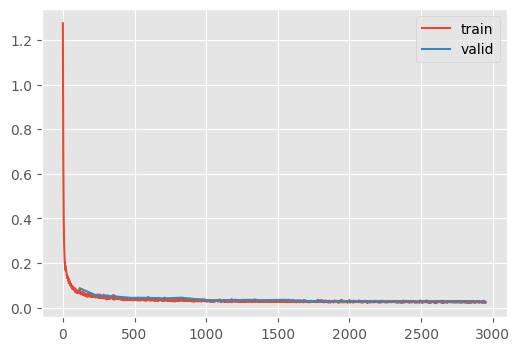

CPU times: user 13min 10s, sys: 24.9 s, total: 13min 34s
Wall time: 13min 42s


In [24]:
%%time
un = train(
    TUnet(
        color_channels=1,
        nfs=(32, 64, 128, 256, 384),
        n_blocks=(3, 2, 1, 1, 1, 1),
    ),
    dls,
    lr=4e-3,
    n_epochs=25,
)

In [31]:
fp = Path("../models/tunet.pt")
if not fp.exists():
    torch.save(un, fp)
else:
    un = torch.load(fp)

In [32]:
xb, _ = dls.peek()
xb.shape

torch.Size([512, 1, 32, 32])

In [33]:
n_steps = 100
ts = torch.linspace(1 - (1 / n_steps), 0, n_steps).to(xb.device)
x_t = torch.randn(16, 3, 64, 64)

In [34]:
# |export
@torch.no_grad()
def ddpm(model, sz=(16, 1, 32, 32), device=def_device, n_steps=100):
    x_0s = []
    x_t = torch.randn(sz, device=device)
    ts = torch.linspace(1 - (1 / n_steps), 0, n_steps).to(device)
    for t, t_next in tqdm(zip(ts, ts[1:]), unit="time step", total=n_steps - 1):
        # Predict the noise for each example in the image
        bs, *_ = x_t.shape
        noise_pred = model(x_t, t.repeat(bs))

        # Predict the image without noise
        x_0_pred = denoisify(x_t, noise_pred, t)
        x_0s.append(x_0_pred)

        # Renoise
        (prev_sample, _), _ = noisify(x_0_pred, t_next)

        # Repeat
        x_t = prev_sample

    # At the last step, simply rescale and do not add noise
    t = tensor(0.0, device=device).repeat(bs)
    x_0 = denoisify(x_t, model(x_t, t), t)
    x_0s.append(x_0_pred)

    return x_0, x_0s

100%|████████████████████████████████████████████████████████████| 99/99 [00:00<00:00, 145.43time step/s]


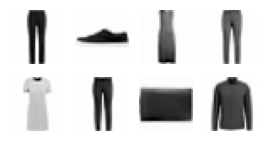

In [35]:
x_0, _ = ddpm(un, (8, 1, 32, 32))
show_images(x_0, imsize=0.8)

This is not bad! This achieves a similar performance to the Huggingface implementation with a simliar number of parameters.

In [1]:
#| hide
import nbdev

nbdev.nbdev_export()